<h2 style="color: #ff5733; 
           font-family: Arial, sans-serif; 
           text-align: center; 
           text-transform: uppercase; 
           letter-spacing: 2px; 
           margin-bottom: 20px;
           border: 2px solid #ff5733;
           padding: 10px;
           animation: color-change 1s infinite alternate;">
    Implementing TSP on 1 Dataset - rd100.tsp.gz
</h2>

<h2 style="color: #007bff; 
           font-family: 'Helvetica', sans-serif; 
           text-align: center; 
           text-transform: capitalize; 
           letter-spacing: 1px; 
           margin-bottom: 15px;
           border: 1px solid #007bff;
           padding: 8px;
           box-shadow: 0 0 10px rgba(0, 123, 255, 0.3);">
       Exploring different datasets is a breeze – just adjust the file path!
</h2>

Simple Hill Climbing Solution: [65 97 30 40 60 10 91 16 45 49 53 32 31 13 84  0 89 95 88 75 52 56 93 51
 63 39 38 28 15 43 44 34  1 22 76 87 83  5 26 72 55 36 27 57  6 99 77  9
  8 11 14 86 17 59 12 62 66 19  2 47 80 29 92 18 48 61 67 70  7 50  4 21
 41 23 35 85 46 20 68 42 24 79 64 82 74 98 78 25 71 69 37 54 33 90 96 81
  3 73 58 94]

Stochastic Hill Climbing Solution: [41 79 48 89 42 10 49 76 16 82 68 12 59 61 47  3 33 55 86 17 97  2 23 75
 19 83 28 43 14 60 66  9 25 13  6 90 45 20 67 22 91 52 26 32 84 94 24  7
 80 34  8 73 74  4 15 18 72  1 30 71 56 36 96 70 57 21 54 64 65 69 37 50
 78 77 11 46 85 92 81 62 63 95 29 39 35 99 38 27 87 93 31 53 88  5 44 98
  0 40 58 51]

Simulated Annealing Solution: [77 20 48 63 33 41  6 89 13 11 16 69 55 85 14 59 70 46  4 67  0  7 68 99
 38 28 44 97 34  1 88  5 52 15 75 92 87 43 39 54 24 47 82 90 96 66 86 17
 61 84  3 31  9 53 37 49 91 98 56 65 72 45 58 94 32  2 81 12 79 80 23 42
 40 21 73 19 18 76 22 83 26 27 35 50 29 95 10 60 64 51 78 93 57 30 36 7

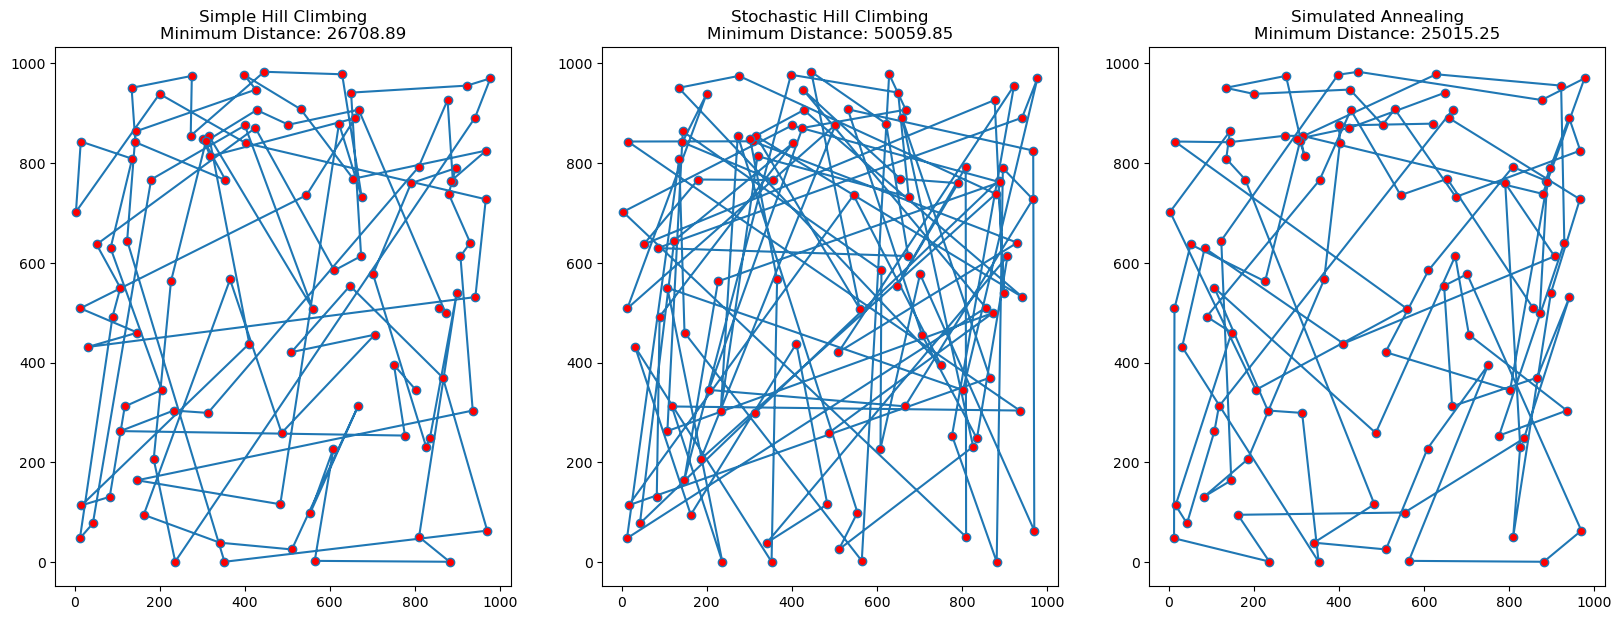

In [3]:
import numpy as np
import scipy.spatial.distance as dist
import gzip
import matplotlib.pyplot as plt
from colorama import Fore, Style
from prettytable import PrettyTable

def read_tsp_data(file_path):
    with gzip.open(file_path, 'rt') as file:
        lines = file.readlines()

    cities = []
    coordinates = []

    for line in lines:
        if line.startswith("DIMENSION"):
            num_cities = int(line.split(":")[1])
            break

    for line in lines[6:6 + num_cities]:
        city_data = line.strip().split()
        cities.append(city_data[0])
        coordinates.append([float(x) for x in city_data[1:]])

    return cities, np.array(coordinates)

def compute_distance_matrix(coordinates):
    return dist.squareform(dist.pdist(coordinates))

def tsp_objective_function(order, distance_matrix):
    rotated_order = np.roll(order, -1)
    return np.sum(distance_matrix[order, rotated_order])

def hill_climbing_iteration(current_solution, distance_matrix):
    idx1, idx2 = np.random.choice(len(current_solution), size=2, replace=False)
    neighbor_solution = current_solution.copy()
    neighbor_solution[idx1], neighbor_solution[idx2] = neighbor_solution[idx2], neighbor_solution[idx1]

    neighbor_distance = tsp_objective_function(neighbor_solution, distance_matrix)
    return neighbor_solution, neighbor_distance

def hill_climbing(initial_solution, distance_matrix, num_iterations=1000):
    current_solution = initial_solution.copy()
    current_distance = tsp_objective_function(current_solution, distance_matrix)

    for _ in range(num_iterations):
        neighbor_solution, neighbor_distance = hill_climbing_iteration(current_solution, distance_matrix)

        if neighbor_distance < current_distance:
            current_solution, current_distance = neighbor_solution, neighbor_distance

    return current_solution, current_distance

def stochastic_hill_climbing(initial_solution, distance_matrix):
    current_solution = initial_solution
    current_distance = tsp_objective_function(current_solution, distance_matrix)

    while True:
        neighbor_solution, neighbor_distance = hill_climbing_iteration(current_solution, distance_matrix)

        if neighbor_distance < current_distance:
            current_solution, current_distance = neighbor_solution, neighbor_distance
        else:
            break

    return current_solution, current_distance

def generate_neighbor_solution(current_solution):
    idx1, idx2 = np.random.choice(len(current_solution), size=2, replace=False)
    neighbor_solution = current_solution.copy()
    neighbor_solution[idx1], neighbor_solution[idx2] = neighbor_solution[idx2], neighbor_solution[idx1]
    return neighbor_solution

def simulated_annealing(initial_solution, distance_matrix, initial_temperature=1000, cooling_rate=0.95, num_iterations=1000):
    current_solution = initial_solution
    current_distance = tsp_objective_function(current_solution, distance_matrix)
    best_solution = current_solution
    best_distance = current_distance

    temperature = initial_temperature

    for _ in range(num_iterations):
        neighbor_solution = generate_neighbor_solution(current_solution)
        neighbor_distance = tsp_objective_function(neighbor_solution, distance_matrix)

        if neighbor_distance < current_distance or np.random.rand() < np.exp((current_distance - neighbor_distance) / temperature):
            current_solution = neighbor_solution
            current_distance = neighbor_distance

            if current_distance < best_distance:
                best_solution = current_solution
                best_distance = current_distance

        temperature *= cooling_rate

    return best_solution, best_distance

def plot_path(ax, coordinates, order, title):
    ordered_coordinates = coordinates[order]
    ax.plot(ordered_coordinates[:, 0], ordered_coordinates[:, 1], 'o-', mfc='r')
    ax.set_title(title)

    
def select_best_local_search(initial_solution, distance_matrix):
    # Run each local search method and compare results
    final_solution_hill_climbing, min_distance_hill_climbing = hill_climbing(initial_solution.copy(), distance_matrix)
    final_solution_stochastic, min_distance_stochastic = stochastic_hill_climbing(initial_solution.copy(), distance_matrix)
    final_solution_simulated_annealing, min_distance_simulated_annealing = simulated_annealing(initial_solution.copy(), distance_matrix)

    # Find the best method based on minimum distance
    methods = {
        'Simple Hill Climbing': min_distance_hill_climbing,
        'Stochastic Hill Climbing': min_distance_stochastic,
        'Simulated Annealing': min_distance_simulated_annealing
    }

    best_method = min(methods, key=methods.get)
    best_solution = None
    best_distance = None

    if best_method == 'Simple Hill Climbing':
        best_solution = final_solution_hill_climbing
        best_distance = min_distance_hill_climbing
    elif best_method == 'Stochastic Hill Climbing':
        best_solution = final_solution_stochastic
        best_distance = min_distance_stochastic
    elif best_method == 'Simulated Annealing':
        best_solution = final_solution_simulated_annealing
        best_distance = min_distance_simulated_annealing

    return best_method, best_solution, best_distance

def main():
    file_path = 'datasets/rd100.tsp.gz'
    cities, coordinates = read_tsp_data(file_path)
    distance_matrix = compute_distance_matrix(coordinates)

    assert len(cities) == len(distance_matrix), "Mismatch between the number of cities and distance matrix size."

    np.random.seed(69)

    # Apply the local search algorithms
    algorithms = [hill_climbing, stochastic_hill_climbing, simulated_annealing]
    algorithm_names = ['Simple Hill Climbing', 'Stochastic Hill Climbing', 'Simulated Annealing']

    # Initialize a list to store all outcomes
    all_outcomes = []

    for algorithm, name in zip(algorithms, algorithm_names):
        initial_solution = np.random.permutation(len(cities))
        solution, distance = algorithm(initial_solution, distance_matrix)
        all_outcomes.append((name, solution, distance))

        # Print the solution for each algorithm
        print(f"{name} Solution: {solution}")
        print("")

    # Select the best outcome
    best_outcome = min(all_outcomes, key=lambda x: x[2])

    # Tabulate the results
    table = PrettyTable()
    table.field_names = ["Algorithm", "Distance"]
    for name, _, distance in all_outcomes:
        if (name, _, distance) == best_outcome:
            table.add_row([Fore.GREEN + name + Style.RESET_ALL, distance])
        else:
            table.add_row([name, distance])
    print(table.get_string())


    # Plot the paths
    fig, axs = plt.subplots(1, len(algorithms), figsize=(20, 7))
    for i, (name, solution, distance) in enumerate(all_outcomes):
        plot_path(axs[i], coordinates, solution, f'{name}\nMinimum Distance: {distance:.2f}')
    plt.show()

if __name__ == "__main__":
    main()